# Change detection for satellite imagery using weights trained on FCN model

### Set variables and import packages

In [25]:
# Variables
# Define data origin
locName = 'dharavi' # File name for area
lat, long = 19.0438, 72.8555 #ochorios 18.406, -77.103 # Lat/Long for center of area of interest
mzoom = 15 # Zoom for interactive map
newLocation = True # Will create new geojson and tiff files

# Data labelling
gjData = False # Location of gdb data (False if no labels, path to file if labels)
dmgAss = "/home/jovyan/gtc-exposure/change_detection/geojsons/"+locName+"Damage.geojson" # Location of geojson (created if newLocation True)
area, defArea = 0.0002, 0.025 # area is radius in lat/long around point label to be considered, defArea is for the case of no labels and defines area box size

# Imagery variables
imgColl, cloudFraction = "sentinel-2:L1C", 0.06 # Image collection and thrshold for cloud cover
bandNum = 1 # 0-[r,g,b], 1-[r,g,b,nir], 2-[r,g,b,cloud-mask,red-edge-2,red-edge-3,red-edge-4,nir,swir1,swir2]
imgNum = 2 # Number of image dates
img_st, img_end = ['2018-08-15','2020-11-01'], ['2018-12-31','2021-02-15'] # Before and after image dates
tifResolution, tifTilesize, tifPad = 10, 1024, 0 # True if first time on location, Size of images defined within AOI determined by geojson

# Data storage
dataPath = "/home/jovyan/OSCD/new/" # Path to save location for generated images

# Model specifications
LOAD_TRAINED = True # Load models (instead of re-training)
newTest = True # False - Add to test files, True - Only test on current area
TYPE = bandNum # Model type ~ band number
modelWeights = '/home/jovyan/gtc-exposure/change_detection/net_final.pth.tar' # Weights file from best trained model (ask Seb for latest)
PATH_TO_TRAIN = "/home/jovyan/OSCD/onera/" # Path to downloaded training data - will look to remove need for this
FP_MODIFIER = 1 # Tuning parameter, use 1 if unsure
PATCH_SIDE = 64
BATCH_SIZE, NORMALISE_IMGS, TRAIN_STRIDE, DATA_AUG = 8, True, int(PATCH_SIDE/2) - 1, False

In [26]:
#%pip install tifffile imagecodecs

# Python packages - if any are not installed use line above or "pip install <package_name>" in terminal
import IPython
import ipywidgets
import ipyleaflet
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import os
import tensorflow as tf
import geopandas as gpd
import importlib
import tifffile
import imagecodecs
from shutil import copyfile
from skimage import io
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
import time
from pprint import pprint
import geojson
from shapely.geometry import Polygon
from pyproj import Proj, transform

from descarteslabs import Storage
import descarteslabs as dl
import descarteslabs.workflows as wf
from descarteslabs.vectors import FeatureCollection, Feature, properties as p

In [27]:
# import PyTorch and model functions
#PyTorch
from packaging import version
import torch
if version.parse(torch.__version__) < version.parse("1.6.0"):
    %pip install torch==1.6.0
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr

# Models
from models.unet import Unet
# from siamunet_conc import SiamUnet_conc
# from siamunet_diff import SiamUnet_diff
# from fresunet import FresUNet
# from smallunet import SmallUnet
# from smallunet_attempt import Unet

print('PyTorch version',torch.__version__,'. If below 1.6.0 you may need to restart kernel.')

PyTorch version 1.6.0 . If below 1.6.0 you may need to restart kernel.


In [28]:
# import custom functions from utils file
from utils_cd import generate_tiff_from_polygons, save_test_results, test

print('IMPORTS OK')

IMPORTS OK


### Plot time separated imagery

In [29]:
# Generate new geojson if necessary
if newLocation and gjData:
    g = gpd.read_file(gjData)
    # Specify portion of database for new geojson file if desired (e.g. select event and lat/longs from FEMA dataset)
    label = g.loc[((g['DMG_LEVEL'] == ('DES'))) & (g['EVENT_NAME'] == 'Hurricane Maria') & (g['LATITUDE'] > 18.4) & (g['LATITUDE'] < 18.45) & (g['LONGITUDE'] > -66.15) & (g['LONGITUDE'] < -65.95)]
    
    features = []
    for i in label.index:
        print(i, len(label.index))
        poly = Polygon([[label.geometry.x[i], label.geometry.y[i]], [label.geometry.x[i]+area, label.geometry.y[i]], [label.geometry.x[i]+area, label.geometry.y[i]+area], [label.geometry.x[i], label.geometry.y[i]+area], [label.geometry.x[i], label.geometry.y[i]]])
        features.append(geojson.Feature(properties={"Damage": label.DMG_LEVEL[i]}, geometry=poly))

    fc = geojson.FeatureCollection(features)
    with open(dmgAss, 'w') as f:
        geojson.dump(fc, f)
        
elif newLocation:
    features = []
    poly = Polygon([[long-defArea, lat-defArea], [long+defArea, lat-defArea], [long+defArea, lat+defArea], [long-defArea, lat+defArea], [long-defArea, lat-defArea]])
    features.append(geojson.Feature(properties={},geometry=poly))
    fc = geojson.FeatureCollection(features)
    with open(dmgAss, 'w') as f:
        geojson.dump(fc, f)

In [48]:
m = wf.interactive.MapApp()
m.center = (lat, long)
m.zoom = mzoom
types = ["red green blue","red green blue nir","red green blue cloud-mask red-edge-2 red-edge-3 red-edge-4 nir swir1 swir2"]
bands = types[bandNum]

for i in range(imgNum):
    img = wf.ImageCollection.from_id(imgColl,start_datetime=img_st[i], end_datetime=img_end[i]).pick_bands(bands)
    img = img.filter(lambda img: img.properties["cloud_fraction"] <= cloudFraction)
    img_msk = img.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1)) if bandNum > 1 else img
    mos = (img_msk.mosaic().pick_bands("red green blue"))
    mos.visualize('Image '+str(i+1), map=m)

if os.path.exists(dmgAss):
    with open(dmgAss) as f: dmg = json.load(f)
    dmg_geojson = ipyleaflet.GeoJSON(data=dmg,
                       style={"color": "red", "lineOpacity": 0.5, "fillOpacity": 0.1},
                       hover_style={"fillOpacity": 0.1})

    m.add_layer(dmg_geojson)
m


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


### Create .tiff files from Sentinel data

In [31]:
# Generate tiff files containing all bands for each tile
for i in range(imgNum):
    out = dataPath+locName+"/imgs_"+str(i+1)+"/"
    dltiles = generate_tiff_from_polygons(dmgAss,
                    products=imgColl,
                    bands=bands,
                    resolution=tifResolution,
                    tilesize=tifTilesize,
                    pad=tifPad,
                    start_datetime=img_st[i],
                    end_datetime=img_end[i],
                    out_folder=out,
                    newLoc=newLocation
                    )

In [32]:
# Separate bands from tiff files and place in correct folder structure for evaluation
if newLocation:    
    file = open(dataPath+'test.txt','w') if newTest else open(dataPath+'test.txt','a') # Open test.txt file
    bandNumbers = [[4,3,2], [4,3,2,8], [4,3,2,1,5,6,7,8,9,10]] # Set appropriate band numbers for Sentinel bands

    for i in range(len([name for name in os.listdir(out) if 'image' in name])): # Loop over tile number from location
        imgFolder = dataPath+locName+'_'+str(i) # Create directory for each tile in location
        if not os.path.exists(imgFolder): os.makedirs(imgFolder)
        file.write(','+locName+'_'+str(i)) if i>0 else file.write(locName+'_'+str(i)) # Write tile number to locations to be tested

        if not os.path.exists(imgFolder+"/cm/"): os.makedirs(imgFolder+"/cm/")
        targDest = imgFolder+"/cm/"+locName+'_'+str(i)+"-cm.tif"
        copyfile(dataPath+locName+"/imgs_1/target_"+str(i)+".tiff", targDest) # Copy target file to tile directory
        imgconv = io.imread(targDest)
        io.imsave(imgFolder+"/cm/cm.png", imgconv)

        for j in range(imgNum): # Loop over time points for images
            img = io.imread(dataPath+locName+"/imgs_"+str(j+1)+"/"+'image_'+str(i)+'.tiff')
            dest = imgFolder+"/imgs_"+str(j+1)
            if not os.path.exists(dest): os.makedirs(dest)

            for k in range(img.shape[2]): # Loop over bands in each image
                io.imsave(dest+"/B"+"{0:0=2d}".format(bandNumbers[bandNum][k])+".tif",img[:,:,k])

    file.close()        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: /home/jovyan/OSCD/new/dharavi_0/cm/cm.png is a low contrast image
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: /home/jovyan/OSCD/new/dharavi_1/cm/cm.png is a low contrast image
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: /home/jovyan/OSCD/new/dharavi_2/cm/cm.png is a low contrast image
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: /home/jovyan/OSCD/new/dharavi_3/cm/cm.png is a low contrast image
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: /home/jovyan/OSCD/new/dharavi_3/imgs_1/B02.tif is a low contrast image
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: /home/jovyan/OSCD/new/dharavi_3/i

### Load in new dataset (need to run Change Detection class at bottom of notebook first)

In [34]:
# Load in new dataset
new_dataset = ChangeDetectionDataset(dataPath, train = False, stride = TRAIN_STRIDE)
new_loader = DataLoader(new_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

 50%|█████     | 3/6 [00:00<00:00, 28.10it/s]

dharavi_0
(512, 512, 4) (512, 512, 4)
dharavi_1
(512, 512, 4) (512, 512, 4)
dharavi_2
(512, 512, 4) (512, 512, 4)
dharavi_3
(512, 512, 4) (512, 512, 4)
dharavi_4
(512, 512, 4) (512, 512, 4)
dharavi_5


100%|██████████| 6/6 [00:00<00:00, 28.35it/s]

(512, 512, 4) (512, 512, 4)


### Load in pre-trained model

In [35]:
# Load in pre-trained model
train_dataset, weights, net, net_name, criterion, params = init_network(DATA_AUG, PATH_TO_TRAIN, TRAIN_STRIDE, TYPE)
print('Trained parameters ', params)

if LOAD_TRAINED:
    net.load_state_dict(torch.load(modelWeights, map_location=torch.device('cpu')),strict=False) #torch.load('/home/jovyan/gtc-exposure/change_detection/net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)

  0%|          | 0/14 [00:00<?, ?it/s]

aguasclaras


  7%|▋         | 1/14 [00:00<00:04,  2.61it/s]

(471, 525, 4) (471, 525, 4)
bercy


 14%|█▍        | 2/14 [00:00<00:04,  2.45it/s]

(395, 360, 4) (395, 360, 4)
bordeaux


 21%|██▏       | 3/14 [00:01<00:04,  2.42it/s]

(517, 461, 4) (517, 461, 4)
nantes


 29%|██▊       | 4/14 [00:01<00:05,  2.00it/s]

(522, 582, 4) (522, 582, 4)
paris


 36%|███▌      | 5/14 [00:02<00:04,  2.08it/s]

(408, 390, 4) (408, 390, 4)
rennes


 43%|████▎     | 6/14 [00:02<00:03,  2.05it/s]

(339, 563, 4) (339, 563, 4)
saclay_e


 50%|█████     | 7/14 [00:03<00:04,  1.68it/s]

(639, 688, 4) (631, 679, 4)
abudhabi


 57%|█████▋    | 8/14 [00:04<00:03,  1.56it/s]

(799, 785, 4) (795, 782, 4)
cupertino


 64%|██████▍   | 9/14 [00:05<00:03,  1.34it/s]

(1015, 788, 4) (1015, 788, 4)
pisa


 71%|███████▏  | 10/14 [00:06<00:03,  1.31it/s]

(776, 718, 4) (776, 718, 4)
beihai


 79%|███████▊  | 11/14 [00:07<00:02,  1.17it/s]

(902, 772, 4) (902, 772, 4)
hongkong


 86%|████████▌ | 12/14 [00:08<00:01,  1.27it/s]

(695, 540, 4) (693, 538, 4)
beirut


 93%|█████████▎| 13/14 [00:09<00:00,  1.02it/s]

(1180, 1070, 4) (1180, 1070, 4)
mumbai


100%|██████████| 14/14 [00:10<00:00,  1.38it/s]

(858, 557, 4) (858, 557, 4)
Trained parameters  1350866


LOAD OK


### Test model on new data

In [36]:
# Generate .png images of detection -> Generates .png results for each tile
t_start = time.time()
save_test_results(new_dataset, net, net_name)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))

  0%|          | 0/6 [00:00<?, ?it/s]/home/jovyan/gtc-exposure/change_detection/utils_cd.py:236: UserWarning: ./results/FC-EF-dharavi_0.png is a low contrast image
  io.imsave(f'./results/{net_name}-{name}.png',I)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
 17%|█▋        | 1/6 [00:01<00:06,  1.34s/it]/home/jovyan/gtc-exposure/change_detection/utils_cd.py:236: UserWarning: ./results/FC-EF-dharavi_1.png is a low contrast image
  io.imsave(f'./results/{net_name}-{name}.png',I)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
 33%|███▎      | 2/6 [00:02<00:05,  1.33s/it]/home/jovyan/gtc-exposure/change_detection/utils_cd.py:236: UserWarning: ./results/FC-EF-dharavi_2.png is a low contrast image
  io.imsave(f'./results/{net_name}-{name}.png',I)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress

Elapsed time: 6.748398303985596


In [23]:
# Assess accuracy
results = test(new_dataset, net, criterion)
pprint(results) if gjData else print('Non-meaningful results, check out imagery results:',results)    

100%|██████████| 2/2 [00:40<00:00, 20.40s/it]

Non-meaningful results, check out imagery results: {'net_loss': 1.8596951961517334, 'net_accuracy': 63.758182525634766, 'class_accuracy': [71.58448028564453, 15.678466796875], 'precision': 0.08241200451906189, 'recall': 0.15678466930761867, 'dice': 0.10803610826847428, 'kappa': -0.0924464796594512}


### Plot result on map

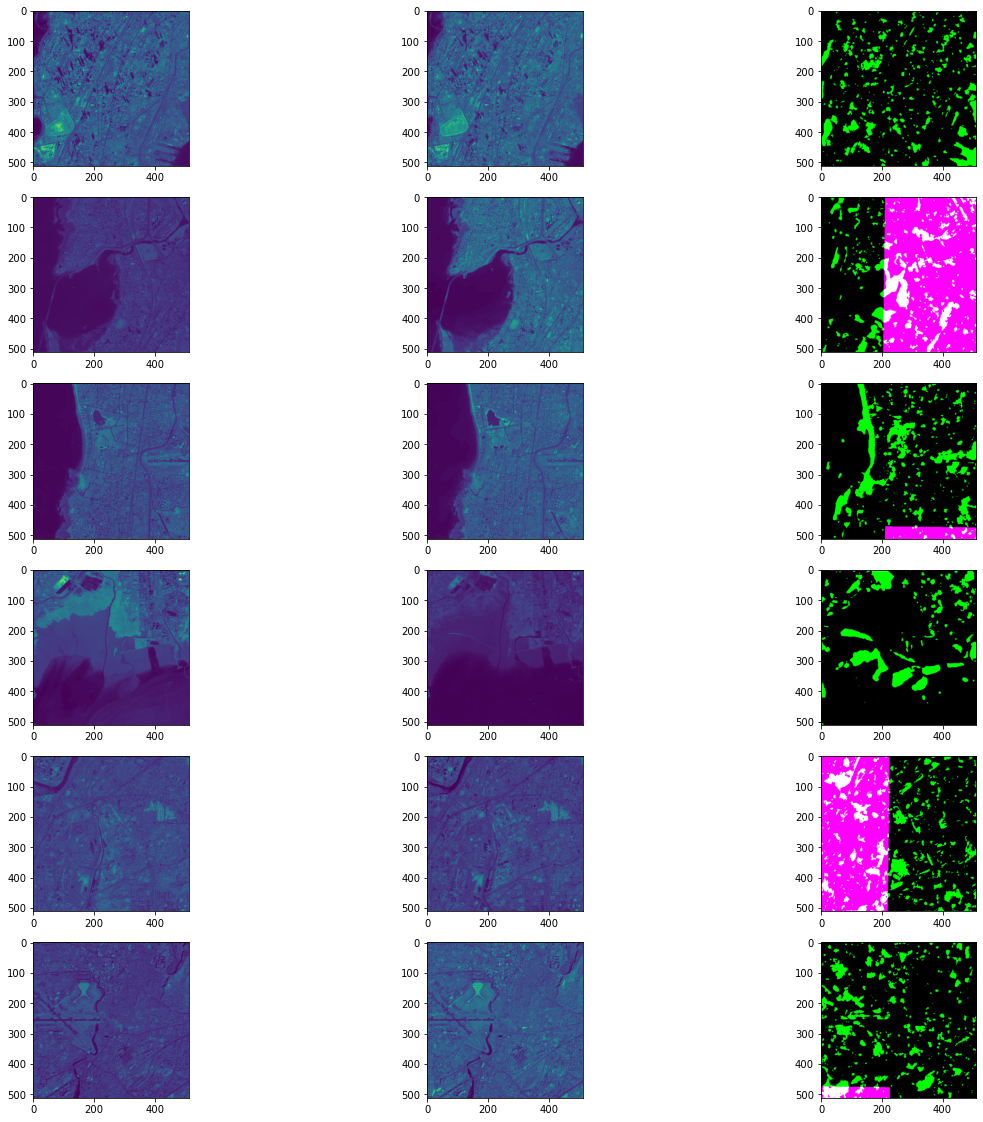

In [46]:
# Show results for each tile of pre-post imagery
import glob
from PIL import Image
band = '8' # r-4, g-3, b-2, nir-8
a = len(glob.glob(dataPath+locName+'_*'))
fig, ax = plt.subplots(a,3, figsize=(20,20))
for folder in range(a):
    img1 = Image.open(dataPath+locName+'_'+str(folder)+'/imgs_1/B0'+band+'.tif')
    img2 = Image.open(dataPath+locName+'_'+str(folder)+'/imgs_2/B0'+band+'.tif')
    res = Image.open('results/FC-EF-'+locName+'_'+str(folder)+'.png')
    ax[folder,0].imshow(img1)
    ax[folder,1].imshow(img2)
    ax[folder,2].imshow(res)

In [45]:
m = wf.interactive.MapApp()
m.center = (lat, long)
m.zoom = mzoom
types = ["red green blue","red green blue nir","red green blue cloud-mask red-edge-2 red-edge-3 red-edge-4 nir swir1 swir2"]
bands = types[bandNum]

for i in range(imgNum):
    img = wf.ImageCollection.from_id(imgColl,start_datetime=img_st[i], end_datetime=img_end[i]).pick_bands(bands)
    img = img.filter(lambda img: img.properties["cloud_fraction"] <= cloudFraction)
    img_msk = img.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1)) if bandNum > 1 else img
    mos = (img_msk.mosaic().pick_bands("red green blue"))
    mos.visualize('Image '+str(i+1), map=m)
    
p = Storage()
for j in range(len(dltiles)):
    key = 'temp'+str(j)
    p.set_file(key=key, file_obj='results/FC-EF-'+locName+'_'+str(j)+'.png', storage_type='data')
    cd = ipyleaflet.ImageOverlay(url=p.get_signed_url(key=key), bounds=(transform(dltiles[j].bounds_crs,'epsg:4326',dltiles[j].bounds[0],dltiles[j].bounds[1]),
                                                                        transform(dltiles[j].bounds_crs,'epsg:4326',dltiles[j].bounds[2],dltiles[j].bounds[3])))
    m.add_layer(cd)

m


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


In [ ]:
# def subtract_mean(feature, target):
#     return feature - 128.0, target

# def get_image(dltile_key):
#     tile = dl.scenes.DLTile.from_key(dltile_key)
#     sc, ctx = dl.scenes.search(aoi=tile, products="sentinel-2:L1C", start_datetime='2017-03-01', end_datetime='2017-09-01')
#     im = sc.mosaic(bands='red green blue', ctx=ctx, bands_axis=-1)
#     ids = [scene.properties.id for scene in sc]
#     acquired_datetime = sc[-1].properties.date.isoformat() # grab the acquired date from the last scene
    
#     metadata = {
#         'acquired_datetime': acquired_datetime,
#         'ids': ids,
#     }
    
#     return im, metadata

# tile = dl.scenes.DLTile.from_latlon(lat, long, resolution=tifResolution, tilesize=tifTilesize, pad=tifPad)
# hr, _ = get_image(tile.key)
# hr = np.expand_dims(hr, axis=0).astype(np.float32)
# hr, _ = subtract_mean(hr, None)
# ax[0,3].imshow((hr.squeeze()+128).astype('uint8'))
# a_target = Image.open('classifier_data/target_3.tiff') #tifffile complains about codecs if you try to use that here
# target_pixel_data = np.reshape(list(a_target.getdata()), (64,64))
# plt.imshow(target_pixel_data)

### Change Detection Dataset class -> could be put in other file

In [33]:
# Functions

def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""
    
    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape
    
    # pad if necessary 
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])
    
    return np.pad(I,((0,p0),(0,p1)),'edge')
    

def read_sentinel_img(path):
    """Read cropped Sentinel-2 image: RGB bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    
    I = np.stack((r,g,b),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_4(path):
    """Read cropped Sentinel-2 image: RGB and NIR bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    I = np.stack((r,g,b,nir),axis=2).astype('float')
    
    I = I.reshape(I.shape[0],I.shape[1],I.shape[2])
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq20(path):
    """Read cropped Sentinel-2 image: bands with resolution less than or equals to 20m."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path):
    """Read cropped Sentinel-2 image: all bands."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_trio(path):
    """Read cropped Sentinel-2 image pair and change map."""
#     read images
    if TYPE == 0:
        I1 = read_sentinel_img(path + '/imgs_1/')
        I2 = read_sentinel_img(path + '/imgs_2/')
    elif TYPE == 1:
        I1 = read_sentinel_img_4(path + '/imgs_1/')
        I2 = read_sentinel_img_4(path + '/imgs_2/')
    elif TYPE == 2:
        I1 = read_sentinel_img_leq20(path + '/imgs_1/')
        I2 = read_sentinel_img_leq20(path + '/imgs_2/')
    elif TYPE == 3:
        I1 = read_sentinel_img_leq60(path + '/imgs_1/')
        I2 = read_sentinel_img_leq60(path + '/imgs_2/')
        
    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0
    
    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    print(s1,s2)
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')
    
    
    return I1, I2, cm



def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)



class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, patch_side = 96, stride = None, use_all_bands = False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride
        
        if train:
            fname = 'train.txt'
        else:
            fname = 'test.txt'
        
#         print(path + fname)
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]
        
        n_pix = 0
        true_pix = 0
        
        
        # load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        for im_name in tqdm(self.names):
            # load and store each image
            print(im_name)
            I1, I2, cm = read_sentinel_img_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm
            
            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()
            
            # calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i
            
            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name, 
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)
                    
        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]   

    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]
        
        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        
        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()
        
        sample = {'I1': I1, 'I2': I2, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

class RandomFlip(object):
    """Flip randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}

class RandomRot(object):
    """Rotate randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}

"""
Network initialisation function
"""
# Initialise network
def init_network(DATA_AUG, PATH_TO_TRAIN, TRAIN_STRIDE, TYPE):
    if DATA_AUG:
        data_transform = tr.Compose([RandomFlip(), RandomRot()])
    else:
        data_transform = None
    train_dataset = ChangeDetectionDataset(PATH_TO_TRAIN, train = True, stride = TRAIN_STRIDE, transform=data_transform)
    weights = torch.FloatTensor(train_dataset.weights)

    # 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

    if TYPE == 0:
        net, net_name = Unet(2*3, 2), 'FC-EF'
    #     net, net_name = Unet(2*3, 2), 'FC-EF'
    #     net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
    #     net, net_name = SiamUnet_diff(3, 2), 'FC-Siam-diff'#
    #     net, net_name = FresUNet(2*3, 2), 'FresUNet'
    elif TYPE == 1:
    #     net, net_name = SmallUnet(2*4, 2), 'FC-EF'
        net, net_name = Unet(2*4, 2), 'FC-EF'
    #     net, net_name = SiamUnet_conc(4, 2), 'FC-Siam-conc'
    #     net, net_name = SiamUnet_diff(4, 2), 'FC-Siam-diff'
    #     net, net_name = FresUNet(2*4, 2), 'FresUNet'
    elif TYPE == 2:
        net, net_name = SmallUnet(2*10, 2), 'FC-EF'
    #     net, net_name = Unet(2*10, 2), 'FC-EF'
    #     net, net_name = SiamUnet_conc(10, 2), 'FC-Siam-conc'
    #     net, net_name = SiamUnet_diff(10, 2), 'FC-Siam-diff'
    #     net, net_name = FresUNet(2*10, 2), 'FresUNet'
    elif TYPE == 3:
        net, net_name = SmallUnet(2*13, 2), 'FC-EF'
    #     net, net_name = Unet(2*13, 2), 'FC-EF'
    #     net, net_name = SiamUnet_conc(13, 2), 'FC-Siam-conc'
    #     net, net_name = SiamUnet_diff(13, 2), 'FC-Siam-diff'
    #     net, net_name = FresUNet(2*13, 2), 'FresUNet'

    criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output
    params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    
    return train_dataset, weights, net, net_name, criterion, params
    
print('UTILS OK')

UTILS OK


## References
Fully Convolutional Networks for Change Detection code for training the network presented in the paper:

```
Daudt, R.C., Le Saux, B. and Boulch, A., 2018, October. Fully convolutional siamese networks for change detection. In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.
```

Code uses the OSCD dataset:

```
Daudt, R.C., Le Saux, B., Boulch, A. and Gousseau, Y., 2018, July. Urban change detection for multispectral earth observation using convolutional neural networks. In IGARSS 2018-2018 IEEE International Geoscience and Remote Sensing Symposium (pp. 2115-2118). IEEE.
```


FresUNet architecture from paper:

```
Daudt, R.C., Le Saux, B., Boulch, A. and Gousseau, Y., 2019. Multitask learning for large-scale semantic change detection. Computer Vision and Image Understanding, 187, p.102783.
```

Please consider all relevant papers if you use this code.

Rodrigo Daudt
rcdaudt.github.io
rodrigo.daudt@onera.fr